In [1]:
import os
from ngs import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

repo_root = os.path.dirname(os.getcwd())

NGS package imported


# Data ingestion and ngs analysis setup

In [2]:
#path to NGS data
p1_nnk = os.path.join(repo_root, "data", "ngs_data", "Rep_1")
p2_nnk = os.path.join(repo_root, "data", "ngs_data", "Rep_2")

#Allowed mutations with NNK is everything
mut_dict_nnk = {
0: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'T', 'V', 'W', 'Y'], #S
1: ['C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #A
2: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'T', 'V', 'W', 'Y'], #S
3: ['A', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #F
4: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W'], #Y
5: ['A', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #F
6: ['A', 'C', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #D
7: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'V', 'W', 'Y'], #T
8: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W'], #Y
9: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #I 
}

#AF1 97 WT Mutation string
wt = 'SASFYFDTYI'

#DMD data objects
d1_nnk = NGS_DMD(
    sequence_type = 'mutations', samples = ['R2', 'R3', 'R5', 'R6', 'R7'],
    path = p1_nnk, wild_type = wt, mutations_dict = mut_dict_nnk
)

d2_nnk = NGS_DMD(
    sequence_type = 'mutations', samples = ['R2', 'R3', 'R5', 'R6', 'R7'],
    path = p2_nnk, wild_type = wt, mutations_dict = mut_dict_nnk
)

['Mutation_1001.csv', 'Mutation_1003.csv', 'Mutation_1005.csv', 'Mutation_1007.csv', 'Mutation_1009.csv']
['Mutation_1001.csv', 'Mutation_1003.csv', 'Mutation_1005.csv', 'Mutation_1007.csv', 'Mutation_1009.csv']


The dataset was first filtered for clones that appeared in both replicates in any round. This `full_clones` set was used to generate PSSMs and PSERMs. A more restrictive set of clones (`potential_clones`) was generated by collecting clones common to both replicates and rounds 2, 3, 5, and 6. Both of the clone sets were filtered for clones lacking "*".

In [3]:
full_clones = set()
for r in d1_nnk.samples:
    full_clones = full_clones.union(common_clones({d1_nnk: [r], d2_nnk: [r]}))
full_clones = [c for c in full_clones if "*" not in c]

clones = common_clones({d1_nnk: ['R2', 'R3', 'R5', 'R6'], d2_nnk: ['R2', 'R3', 'R5', 'R6']})
potential_clones = [c for c in clones if "*" not in c]

The `full_clones` set was used to generate the averaged `ngs_analysis` object to construct scoring matrices.

In [4]:
d_nnk = ngs_analysis(
    replicates = [d1_nnk, d2_nnk],
    common_rounds = ['R2', 'R3', 'R5', 'R6', 'R7'],
    clone_set = full_clones
)

# generate data matrix containing clones and averaged frequencies
d_nnk.generate_D()

# generate PSSMs for each round
for sample in d_nnk.samples:
    d_nnk.generate_PSSM(sample, pseudocount="proportional")

# generate PSERMs for rounds of interest and score all clones
d_nnk.generate_PSERM(In_sample = "R5", Out_sample = "R6")
d_nnk.generate_PSERM(In_sample = "R6", Out_sample = "R7")
d_nnk.score_all_clones_mp()

Generating MSA.


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 83.01it/s]


Done in 0.01 minutes


In [5]:
# Create score cutoffs - top 4 for both R6 and R7
n = 40
subset = d_nnk.scores.loc[potential_clones]

result = subset.apply(lambda col: col.nlargest(n).iloc[-1])
result

R6 PSERM Score    0.737148
R7 PSERM Score    1.140329
dtype: float64

# Figure 2A

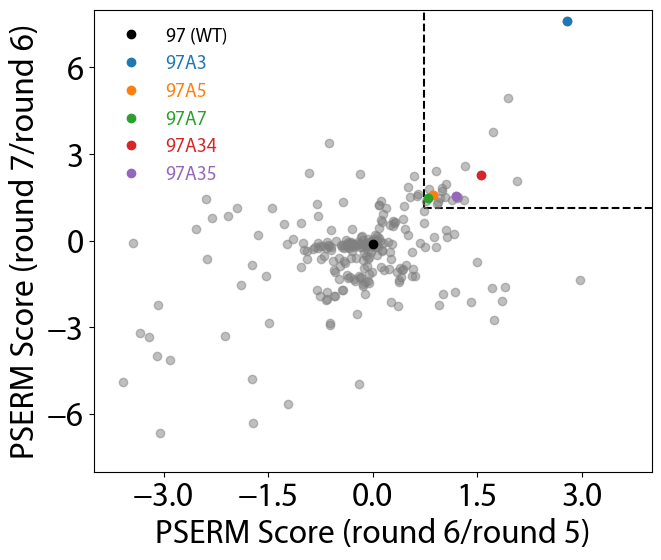

In [6]:
fpath = "/Library/Fonts/Myriad Pro Regular.ttf"
if os.path.exists(fpath):
    prop = fm.FontProperties(fname = fpath, size = 24)
    propg = fm.FontProperties(fname = fpath, size = 14)
else:
    prop = fm.FontProperties(size = 24)
    propg = fm.FontProperties(size = 14)
    
fig, axs = plt.subplots(1, 1, figsize = (7.2, 6))

axs.plot([result["R6 PSERM Score"], result["R6 PSERM Score"]], [result["R7 PSERM Score"], 8.1], '--', color = 'k')
axs.plot([result["R6 PSERM Score"], 4], [result["R7 PSERM Score"], result["R7 PSERM Score"]], '--', color = 'k')
axs.set_xlabel('PSERM Score (round 6/round 5)', fontproperties = prop)
axs.set_ylabel('PSERM Score (round 7/round 6)', fontproperties = prop)

axs.xaxis.set_ticks([-3.0, -1.5, 0.0, 1.5, 3.0])
axs.set_xlim([-4, 4])
axs.yaxis.set_ticks([-6, -3, 0, 3, 6])
axs.set_ylim([-8, 8])

for tick in axs.get_xticklabels():
    tick.set_fontproperties(prop)
for tick in axs.get_yticklabels():
    tick.set_fontproperties(prop)

axs.plot(
    d_nnk.scores.loc[potential_clones, 'R6 PSERM Score'], 
    d_nnk.scores.loc[potential_clones, 'R7 PSERM Score'], 
    "o", 
    alpha = 0.5, 
    color = "grey",
)

clone_names = pd.read_csv(os.path.join(repo_root, "data", "clone_names.csv"), index_col = 0)
clones_of_interest = ["97A3", "97A5", "97A7", "97A34", "97A35", "97"]

for seq in clone_names.index:
    name = clone_names.loc[seq, "Clone"]
    if name in clones_of_interest:
        if name != "97":
            color = plt.get_cmap("tab10")(clones_of_interest.index(name))
            label = name
        else:
            color = "k"
            label = f"{name} (WT)"
            
        axs.plot(
            d_nnk.scores.loc[seq, "R6 PSERM Score"],
            d_nnk.scores.loc[seq, "R7 PSERM Score"],
            "o",
            color = color,
            label = label
        )
        
plt.legend(frameon = False, labelcolor = "linecolor", prop = propg)
plt.savefig(os.path.join(repo_root, "results", 'Figure-2A.pdf'), dpi = 600, bbox_inches = 'tight')
plt.show()

## Figure 2B

In [7]:
clone_names = pd.read_csv(os.path.join(repo_root, "data", "clone_names.csv"), index_col = 0)

clone_names["R7_score"] = d_nnk.scores.loc[clone_names.index, "R7 PSERM Score"]
clone_names["R7_score"] = d_nnk.scores.loc[clone_names.index, "R6 PSERM Score"]

filtered = clone_names[~clone_names.index.str.contains("C")]
filtered = filtered[
    (filtered["R6_score"] > result['R6 PSERM Score']) &
    (filtered["R7_score"] > result['R7 PSERM Score'])
]
filtered = filtered.sort_values("R7_score", ascending=False)

if d_nnk.wt in clone_names.index:
    wt_row = clone_names.loc[[d_nnk.wt]]
    filtered = filtered.drop(index=d_nnk.wt, errors="ignore")
    filtered = pd.concat([wt_row, filtered])

selected_scores = np.zeros(shape = (len(filtered), len(d_nnk.wt)))
for i, seq in enumerate(filtered.index):
    for j, aa in enumerate(seq):
        selected_scores[i, j] = d_nnk.PSERM["R7"].loc[aa, j]

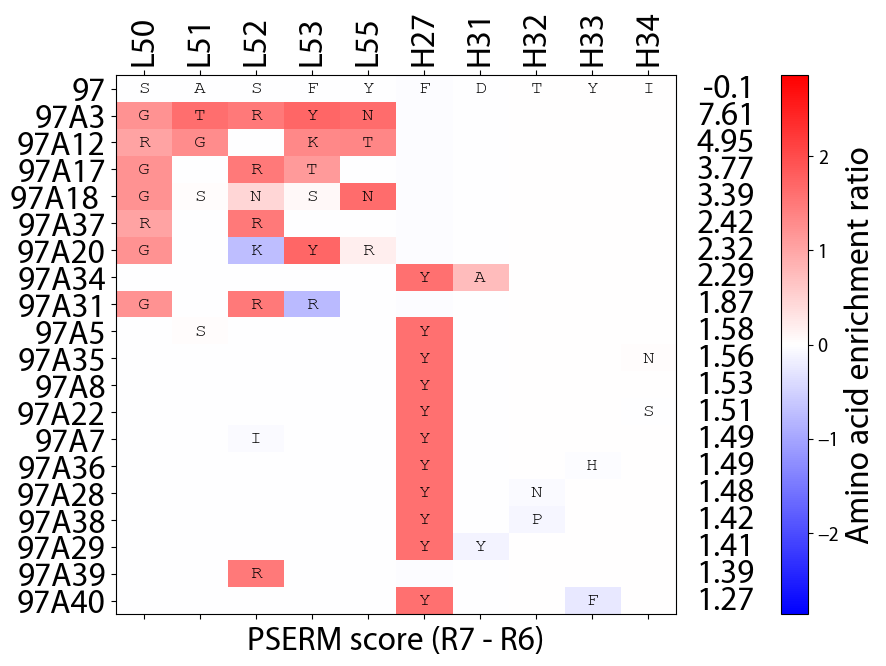

In [11]:
fpathl = "/Library/Fonts/cour.ttf"
if os.path.exists(fpathl):
    aaprop = fm.FontProperties(fname = fpathl, size = 14)
else:
    aaprop = fm.FontProperties(size = 14)

fpath = "/Library/Fonts/Myriad Pro Regular.ttf"
if os.path.exists(fpath):
    prop = fm.FontProperties(fname = fpath, size = 24)
    propg = fm.FontProperties(fname = fpath, size = 14)
else:
    prop = fm.FontProperties(size = 24)
    propg = fm.FontProperties(size = 14)

fig, axs = plt.subplots(1, 1, figsize = (9, 7))

cax1 = axs.matshow(selected_scores, aspect = 'auto', cmap = 'bwr', vmin = -2.86, vmax = 2.86)

axs.set_xticks(list(range(10)))
axs.set_xticklabels(['L50', 'L51', 'L52', 'L53', 'L55', 'H27', 'H31', 'H32', 'H33', 'H34'], rotation = 90, fontproperties = prop)
    
labels = []
for seq in filtered.index:
    labels.append(filtered.loc[seq, 'Clone'])
    
axs.set_yticks(list(range(len(labels))))
axs.set_yticklabels(labels, fontproperties = prop)
axs.set_xlabel(r'PSERM score (R7 - R6)', fontproperties = prop)

for i, seq in enumerate(filtered.index):
    for j, AA in enumerate(seq):
        #labels score on i, AA in PSSM
        if AA != wt[j] or i == 0:
            axs.text(
                j, 
                i,  
                AA,
                ha = 'center', va = 'center', fontproperties = aaprop
            )
    axs.text(
        j + 1.9,
        i,
        round(filtered.loc[seq, "R7_score"], 2),
        ha = 'right', va = 'center', fontproperties = prop
    )
    
cbar = fig.colorbar(cax1, ax=axs, orientation='vertical', fraction=0.046, pad=0.15)
cbar.set_label("Amino acid enrichment ratio", fontproperties = prop)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(propg)

plt.savefig(os.path.join(repo_root, "results", 'Figure-2B.pdf'), transparent = True, dpi = 600)
plt.show()